In [43]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import numpy as np
import os
import random


def snake_func(x, a=1):
    return x + tf.square(tf.math.sin(a * x))
    if tf.math.floor(val) % 2 == 1:
        return 0
    return 1


'''generate a dataset of an analytic function between the given bounds'''
def gen_func_dataset(lower_limit, upper_limit, func, gap=0.01):
    inputs = tf.reshape(tf.range(lower_limit, upper_limit, gap), (-1, 1))
    if func == "identity":
        outputs = inputs
    elif func == "tanh":
        outputs = tf.math.tanh(inputs)
    elif func == "sin":
        outputs = tf.math.sin(inputs)
    elif func == "square":
        outputs = tf.square(inputs)
    elif func == "step":
        outputs = tf.reshape(tf.constant([step(i) for i in inputs]), (-1, 1))
    elif func == "sinusoid":
        outputs = tf.math.sin(inputs) + tf.math.sin(4 * inputs) / 4
    else:
        raise Exception("Unknown function")
    return inputs, outputs


'''sample num_points points from the generated dataset'''
def sample_func_dataset(dataset_inputs, dataset_outputs, lower_lim, upper_lim, num_points):
    valid_indices = tf.where((dataset_inputs >= lower_lim) & (dataset_inputs <= upper_lim))

    sampled_indices = tf.gather(valid_indices, tf.random.shuffle(tf.range(len(valid_indices)))[:num_points])

    sampled_inputs = tf.gather(dataset_inputs, sampled_indices)
    sampled_outputs = tf.gather(dataset_outputs, sampled_indices)

    return sampled_inputs, sampled_outputs


def normalize(sampled_inputs, function_inputs):
    scaler = MinMaxScaler()

    normalized_sample_inputs = tf.constant(scaler.fit_transform(sampled_inputs.numpy()))
    normalized_function_inputs = tf.constant(scaler.transform(function_inputs.numpy()))

    return normalized_sample_inputs, normalized_function_inputs


'''functions to train for the various experiments and datasets'''
def train_extrapolation(model, train_inputs, train_outputs, epochs, verbose=False):
    train_losses = []

    optimizer = keras.optimizers.SGD(learning_rate=1e-3)
    criterion = keras.losses.MeanSquaredError()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            preds = model(x)
            loss = criterion(y, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss

    for epoch in tqdm(range(1, epochs + 1), disable=not verbose):
        loss = train_step(train_inputs, train_outputs)
        train_losses.append(loss.numpy())
        if verbose:
            print(f"Loss on epoch {epoch}= {loss.numpy()}")

    return model , train_losses


In [44]:
def train_mnist(model, train_dataloader, epochs, verbose=False):
    train_losses = []

    optimizer = keras.optimizers.SGD(lr=1e-2)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

    for epoch in tqdm(range(1, epochs+1), disable = not verbose):
        train_loss_total = 0
        num_steps = 0

        for i, (X, y) in enumerate(train_dataloader):
            loss = model.train_on_batch(X, y)

            train_loss_total += loss
            num_steps += 1

        train_losses.append(train_loss_total/num_steps)

        if verbose:
            print(f"Loss on epoch {epoch} = {train_losses[-1]}")

    return model, train_losses


def train_cifar(model, train_dataloader, test_dataloader, epochs, verbose=False):
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    optimizer = keras.optimizers.LaProp(lr=4e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    for epoch in tqdm(range(1, epochs+1), disable = not verbose):
        train_loss_total = 0.0
        num_steps = 0
        correct = 0
        ### Train
        for i, batch in enumerate(train_dataloader):
            X, y = batch[0], batch[1]
            loss, accuracy = model.train_on_batch(X, y)

            train_loss_total += loss
            num_steps += 1
            correct += accuracy*X.shape[0]

        train_loss_total_avg = train_loss_total / num_steps
        train_accuracy = correct/len(train_dataloader.dataset)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss_total_avg)

        test_loss_total = 0.0
        num_steps = 0
        correct = 0
        for i, batch in enumerate(test_dataloader):
            X, y = batch[0], batch[1]

            loss, accuracy = model.evaluate(X, y, verbose=0)
            test_loss_total += loss
            num_steps += 1
            correct += accuracy*X.shape[0]

        test_loss_total_avg = test_loss_total / num_steps
        test_accuracy = correct/len(test_dataloader.dataset)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss_total_avg)

        if verbose:
            print(f"Train accuracy on epoch {epoch}= {train_accuracies[-1]}")
            print(f"Test accuracy on epoch {epoch}= {test_accuracies[-1]}")

    return model, test_accuracies


In [45]:
def train_atmospheric_financial(model, train_dataloader, test_dataloader, epochs, verbose=False):
    train_losses = []
    test_losses = []

    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    device = "/GPU:0" if tf.test.gpu_device_name() else "/CPU:0"

    criterion = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(lr=0.01)

    for epoch in tqdm(range(1, epochs+1), disable=not verbose):
        train_loss_total = 0.0
        num_steps = 0

        for batch in train_dataloader:
            X, y = batch[0], batch[1]

            with tf.device(device):
                train_preds = model(X)

                loss = criterion(y, train_preds)
                train_loss_total += loss.numpy()

                grads = tf.gradients(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                num_steps += 1

        train_loss_total_avg = train_loss_total / num_steps
        train_losses.append(train_loss_total_avg)

        test_loss_total = 0.0
        num_steps = 0

        for batch in test_dataloader:
            X, y = batch[0], batch[1]

            with tf.device(device):
                test_preds = model(X)
                loss = criterion(y, test_preds)
                test_loss_total += loss.numpy()

            num_steps += 1

        test_loss_total_avg = test_loss_total / num_steps
        test_losses.append(test_loss_total_avg)

        if verbose:
            print(f"Train loss on epoch {epoch} = {train_losses[-1]}")
            print(f"Test loss on epoch {epoch} = {test_losses[-1]}")

    return model, train_losses, test_losses

def train_mlp_sin_noise(model, train_inputs, train_outputs, test_inputs, test_outputs, epochs, verbose=False):
    train_losses = []
    test_losses = []

    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")
    device = "/GPU:0" if tf.test.gpu_device_name() else "/CPU:0"

    criterion = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(lr=0.01)

    for epoch in tqdm(range(1, epochs+1), disable=not verbose):

        with tf.device(device):
            preds = model(train_inputs)
            loss = criterion(train_outputs, preds)

            grads = tf.gradients(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_losses.append(loss.numpy())

            preds = model(test_inputs)
            loss = criterion(test_outputs, preds)
            test_losses.append(loss.numpy())

        if verbose:
            print(f"Train loss on epoch {epoch} = {loss.numpy()}")
            print(f"Test loss on epoch {epoch} = {loss.numpy()}")

    return model, train_losses, test_losses


In [46]:
def train_rnn_sin_noise(rnn, train_seqs, test_seqs, epochs, verbose=False):

    train_losses = []
    test_losses = []

    loss_function = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.Adam(lr=1e-3)

    for i in tqdm(range(epochs), disable = not verbose):
        loss = 0
        steps = 0
        for seq, labels in train_seqs:
            seq, labels = seq.to(device), labels.to(device)

            with tf.GradientTape() as tape:
                rnn.hidden_cell = tf.zeros((1, 1, rnn.hidden_layer_size))
                y_pred = rnn(seq)
                single_loss = loss_function(y_pred, labels)

            gradients = tape.gradient(single_loss, rnn.trainable_variables)
            optimizer.apply_gradients(zip(gradients, rnn.trainable_variables))

            loss += single_loss.numpy()
            steps += 1

        train_losses.append(loss/steps)

        loss = 0
        steps = 0
        for seq, labels in test_seqs:
            seq, labels = seq.to(device), labels.to(device)
            rnn.hidden_cell = tf.zeros((1, 1, rnn.hidden_layer_size))

            y_pred = rnn(seq)

            single_loss = loss_function(y_pred, labels)
            loss += single_loss.numpy()
            steps += 1

        test_losses.append(loss/steps)

    return rnn, train_losses, test_losses


def train_sinusoid(model, X, y, epochs, verbose=False):

    train_losses = []

    device = "cuda" if tf.test.is_gpu_available() else "cpu"
    model = model.to(device)
    X = X.to(device)
    y = y.to(device)

    criterion = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.Adam()

    for epoch in tqdm(range(1, epochs+1), disable = not verbose):
        with tf.GradientTape() as tape:
            train_preds = model(X)
            loss = criterion(train_preds, y)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_losses.append(loss.numpy())

        if verbose:
            print("\nTrain loss: {:.4f}".format(loss.numpy()))

    return model, train_losses


'''generate dataset for RNN'''
def create_inout_sequences(input_data, window=10):
    sequences = []
    L = len(input_data)
    for i in range(L-window):
        input_seq = input_data[i:i+window]
        output = input_data[i+window:i+window+1]
        sequences.append((input_seq, output))
    return sequences

'''add noise to the sinusoidal function sin(x/10)'''
def sin_with_noise(low_bound=0, up_bound=300, step=1, train_split=200, sigma=0.0):
    X = tf.range(low_bound, up_bound, step)
    y = tf.math.sin(X/10)
    dist = tf.distributions.Normal(0, sigma)
    y_plus_eps = y[:train_split] + dist.sample((train_split,))
    return X, y, y_plus_eps

In [47]:
class SinActivation(layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.sin(x)

class SinPlusCosActivation(layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.sin(x) + tf.cos(x)

class XPlusSinActivation(layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return x + tf.sin(x)

class SnakeActivation(layers.Layer):
    def __init__(self, a=1):
        super().__init__()
        self.a = a

    def call(self, x):
        return x + tf.square(tf.sin(self.a * x))/self.a

class LearnedSnake(layers.Layer):
    def __init__(self):
        super().__init__()
        self.a = tf.Variable(tf.random.normal(shape=(1,)))

    def call(self, x):
        return x + tf.square(tf.sin(self.a * x))/self.a

class SimpleMLP(tf.keras.Model):
    def __init__(self, layer_sizes, hidden_activation):
        super().__init__()
        self.layers1 = []
        self.layers1.append(layers.Flatten())
        for k in range(len(layer_sizes)-2):
            self.layers1.append(layers.Dense(layer_sizes[k+1]))
            if hidden_activation == "tanh":
                self.layers1.append(layers.Activation(tf.keras.activations.tanh))
            elif hidden_activation == "relu":
                self.layers1.append(layers.Activation(tf.keras.activations.relu))
            elif hidden_activation == "sin":
                self.layers1.append(SinActivation())
            elif hidden_activation == "sin_plus_cos":
                self.layers1.append(SinPlusCosActivation())
            elif hidden_activation[:5] == "snake":
                if hidden_activation == "snake":
                    a = 1
                else:
                    a = float(hidden_activation[8:])
                self.layers1.append(SnakeActivation(a))
            elif hidden_activation == "learned_snake":
                self.layers1.append(LearnedSnake())
            elif hidden_activation == "x_sin":
                self.layers1.append(XPlusSinActivation())
            else:
                raise Exception("Unknown activation")
        self.layers1.append(layers.Dense(layer_sizes[-1]))

    def call(self, x):
        for layer in self.layers1:
            x = layer(x)
        return x


In [48]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Activation, RNN, SimpleRNN

def ResNet18WithActivation(activation):
    resnet18 = models.resnet18(pretrained=True, progress=True)
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = resnet18.maxpool(x)
    x = resnet18.layer1(x)
    x = resnet18.layer2(x)
    x = resnet18.layer3(x)
    x = resnet18.layer4(x)
    x = resnet18.avgpool(x)
    x = Flatten()(x)
    x = Dense(10)(x)
    x = Activation(activation)(x)

    model = Model(inputs=inputs, outputs=x)
    return model

class RNN(Model):
    def __init__(self, input_size=1, hidden_layer_size=64, output_size=1, activation="relu"):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = SimpleRNN(hidden_layer_size, activation=activation)
        self.linear = Dense(output_size)

    def call(self, input_seq):
        rnn_out = self.rnn(input_seq)
        predictions = self.linear(rnn_out)
        return predictions[-1]


In [49]:
import matplotlib.pyplot as plt

In [ ]:
ensure_reproducibility(42)

In [51]:
def visualize_snake(lower_lim=-2, upper_lim=2, a_values=[1, 0.2, 5]):
    x = np.arange(lower_lim, upper_lim, 0.1)
    for a in a_values:
        plt.plot(x, snake_func(x, a), label="a = "+str(a))
    plt.legend()
    plt.show()

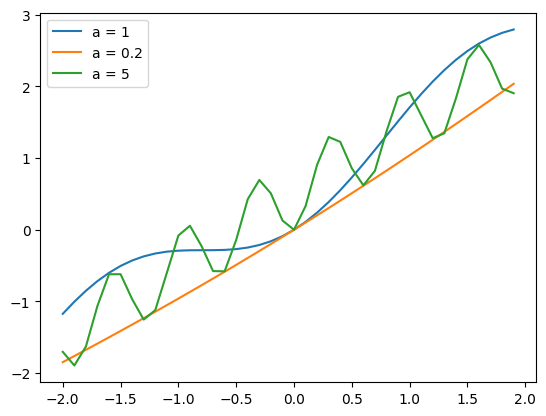

In [53]:
visualize_snake()

In [54]:
import numpy as np

In [55]:
sin_inputs, sin_outputs = gen_func_dataset(lower_limit=-20, upper_limit=20, func="sin")
sample_inputs1, sample_outputs1 = sample_func_dataset(dataset_inputs=sin_inputs, dataset_outputs=sin_outputs, lower_lim=-5, upper_lim=-1, num_points=50)
sample_inputs2, sample_outputs2 = sample_func_dataset(dataset_inputs=sin_inputs, dataset_outputs=sin_outputs, lower_lim=1, upper_lim=5, num_points=50)

In [56]:
sample_inputs = tf.concat([sample_inputs1,sample_inputs2],axis=1)
sample_outputs = tf.concat([sample_outputs1,sample_outputs2],axis=1)

125/125 [==============================] - 0s 878us/step


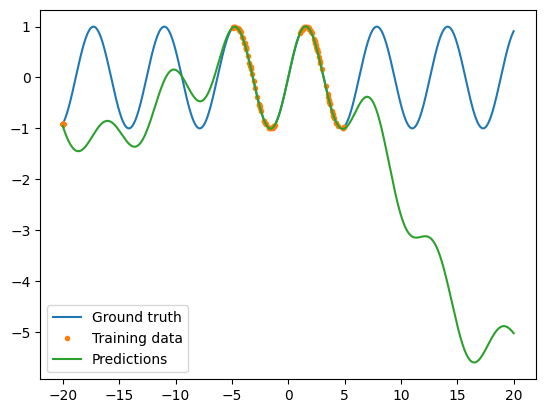

In [57]:
# define the activations and their corresponding labels
activations = ["SnakeActivation"]
labels = [ "SnakeActivation"]

# define the architecture of the model
ARCHITECTURE = [1, 512, 1]
EPOCHS = 3000

# create a simple MLP model
def create_model(activation):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(512),
        SnakeActivation(),
        tf.keras.layers.Dense(1)
    ])
    return model

# #define the training function
def train_extrapolation(model, X_train, y_train, epochs, verbose):
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.MeanSquaredError())
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
    train_losses = history.history["loss"]
    return model, train_losses

for activation, label in zip(activations, labels):
    model = create_model(activation)
    model, train_losses = train_extrapolation(model, np.array(sample_inputs).reshape(200), np.array(sample_outputs).reshape(200), epochs=EPOCHS, verbose=False)
    preds_train = model.predict(np.array(sin_inputs).reshape(4000))
    # preds_test = model.predict(np.array(sample_outputs).reshape(200))
    
    # plt.plot(np.vstack((preds_train, preds_test)), label="prediction, " + label)
plt.plot(sin_inputs, sin_outputs, label="Ground truth")
plt.plot(np.array(sample_inputs).reshape(200), np.array(sample_outputs).reshape(200), '.', label="Training data")
plt.plot(sin_inputs, preds_train, label="Predictions")
plt.legend()


In [15]:
ARCHITECTURE = (28*28, 512, 512, 512, 10)
EPOCHS = 50
BATCH_SIZE = 32

In [16]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist

def mnist_dataloaders(batch_size=32):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    trainloader = keras.preprocessing.image.ImageDataGenerator().flow(x_train, y_train, batch_size=batch_size, shuffle=True)
    testloader = keras.preprocessing.image.ImageDataGenerator().flow(x_test, y_test, batch_size=batch_size, shuffle=False)

    return trainloader, testloader


In [ ]:
# train_mnist_dataloader, _ = mnist_dataloaders()
activations = ["relu", "sin", "x_sin", "snake_a=1"]
labels = ["ReLU", "sin(x)", "x + sin(x)", "x + sin\u00b2x"]
plt.yscale("log")
for activation, label in zip(activations, labels):
    print(f"Training on MNIST with {label} activation")
    model = SimpleMLP(ARCHITECTURE, activation)
    model, losses = train_mnist(model, train_mnist_dataloader, epochs=EPOCHS, verbose=False)
    plt.plot(losses, label=label)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()